In [107]:
# STEP 1: Sensor Data Preprocessing with Google Drive Support

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os
from scipy.ndimage import gaussian_filter1d

In [2]:
# === 1. Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [108]:

# === 2. Set paths ===
# Modify these paths as needed
GDRIVE_BASE_PATH = "/content/drive/MyDrive/Project Dataset/MTP Dataset"
FD_FILENAME = "train_FD001.txt"
OUTPUT_FILENAME = "preprocessed_fd001.csv"

input_path = os.path.join(GDRIVE_BASE_PATH, FD_FILENAME)
output_path = os.path.join(GDRIVE_BASE_PATH, OUTPUT_FILENAME)


In [109]:
# === 3. Sensor Filtering Function with Diagnostics ===
def identify_constant_sensors(df, sensor_cols, threshold=1e-2):
    low_var_sensors = []
    print("\n📊 Sensor Standard Deviations:")
    for col in sensor_cols:
        std = df[col].std()
        print(f"{col}: std = {std:.6f}")
        if std < threshold:
            low_var_sensors.append(col)
    print(f"\n Dropped sensors (std < {threshold}): {low_var_sensors}")
    return low_var_sensors


In [110]:
# === 4. Full Preprocessing Function ===
def load_and_preprocess_cmapps(fd_path: str, save_path: str, threshold: float = 1e-2):
    df = pd.read_csv(fd_path, sep=" ", header=None)
    df.dropna(axis=1, how='all', inplace=True)

    col_names = ['unit', 'cycle'] + \
                [f'op_setting_{i}' for i in range(1, 4)] + \
                [f'sensor_{i}' for i in range(1, 22)]
    df.columns = col_names

    # Identify and drop low-variance sensors
    sensor_cols = [col for col in df.columns if 'sensor_' in col]
    constant_sensors = identify_constant_sensors(df, sensor_cols, threshold)
    df.drop(columns=constant_sensors, inplace=True)

    # Normalize retained sensors
    sensor_cols = [col for col in df.columns if 'sensor_' in col]
    scaler = MinMaxScaler()
    df[sensor_cols] = scaler.fit_transform(df[sensor_cols])
    print("\n Normalized sensor columns.")

    # Add RUL labels
    max_cycle = df.groupby('unit')['cycle'].max().reset_index()
    max_cycle.columns = ['unit', 'max_cycle']
    df = df.merge(max_cycle, on='unit')
    df['RUL'] = df['max_cycle'] - df['cycle']
    df.drop(columns=['max_cycle'], inplace=True)

    df.to_csv(save_path, index=False)
    print(f"\n Preprocessed data saved to: {save_path}")
    return df

In [111]:
# === 5. Run Preprocessing ===
if os.path.exists(input_path):
    df_cleaned = load_and_preprocess_cmapps(input_path, output_path, threshold=1e-2)
else:
    print(f" File not found at: {input_path}. Please upload 'train_FD001.txt' to: {GDRIVE_BASE_PATH}")


📊 Sensor Standard Deviations:
sensor_1: std = 0.000000
sensor_2: std = 0.500053
sensor_3: std = 6.131150
sensor_4: std = 9.000605
sensor_5: std = 0.000000
sensor_6: std = 0.001389
sensor_7: std = 0.885092
sensor_8: std = 0.070985
sensor_9: std = 22.082880
sensor_10: std = 0.000000
sensor_11: std = 0.267087
sensor_12: std = 0.737553
sensor_13: std = 0.071919
sensor_14: std = 19.076176
sensor_15: std = 0.037505
sensor_16: std = 0.000000
sensor_17: std = 1.548763
sensor_18: std = 0.000000
sensor_19: std = 0.000000
sensor_20: std = 0.180746
sensor_21: std = 0.108251

✅ Dropped sensors (std < 0.01): ['sensor_1', 'sensor_5', 'sensor_6', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19']

✅ Normalized sensor columns.

✅ Preprocessed data saved to: /content/drive/MyDrive/Project Dataset/MTP Dataset/preprocessed_fd001.csv


In [112]:
# STEP 2: Parallel Sensor Gaussian Smoothing (PSGS) with Google Drive
# === 2. Set file paths ===
GDRIVE_BASE_PATH = "/content/drive/MyDrive/Project Dataset/MTP Dataset"
INPUT_FILENAME = "preprocessed_fd001.csv"
OUTPUT_FILENAME = "smoothed_fd001.csv"

input_path = os.path.join(GDRIVE_BASE_PATH, INPUT_FILENAME)
output_path = os.path.join(GDRIVE_BASE_PATH, OUTPUT_FILENAME)

In [113]:
# === 3. PSGS Function ===
def apply_psgs(df: pd.DataFrame, sensor_columns: list, sigma: float = 2.0) -> pd.DataFrame:
    """
    Apply Gaussian smoothing per unit and sensor independently.
    Args:
        df: Preprocessed DataFrame (from Step 1)
        sensor_columns: List of sensor columns to smooth
        sigma: Std. dev. for Gaussian kernel (higher = more smoothing)
    Returns:
        df_smoothed: Copy of df with smoothed sensor signals
    """
    df_smoothed = df.copy()
    for unit_id, group in df.groupby("unit"):
        for sensor in sensor_columns:
            signal = group[sensor].values
            smoothed_signal = gaussian_filter1d(signal, sigma=sigma, mode='nearest')
            df_smoothed.loc[group.index, sensor] = smoothed_signal
    return df_smoothed

In [114]:
# === 4. Apply PSGS and Save ===
if os.path.exists(input_path):
    df = pd.read_csv(input_path)
    sensor_cols = [col for col in df.columns if 'sensor_' in col]

    df_smoothed = apply_psgs(df, sensor_columns=sensor_cols, sigma=2.0)
    df_smoothed.to_csv(output_path, index=False)

    print(f"Smoothed data saved to: {output_path}")
else:
    print(f"File not found: {input_path}. Please run Step 1 first or upload the preprocessed file.")

✅ Smoothed data saved to: /content/drive/MyDrive/Project Dataset/MTP Dataset/smoothed_fd001.csv


In [115]:
# STEP 3 (Fixed): Particle Filter with Sensor Interpolation Model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

# === 1. Load smoothed dataset ===
data_path = "/content/drive/MyDrive/Project Dataset/MTP Dataset/smoothed_fd001.csv"
df = pd.read_csv(data_path)
sensor_cols = [col for col in df.columns if "sensor_" in col]

# === 2. Compute healthy & degraded reference vectors across all units ===
def get_reference_vectors(df, sensor_cols):
    healthy_vecs = []
    degraded_vecs = []
    for uid in df['unit'].unique():
        unit_df = df[df['unit'] == uid]
        healthy_vecs.append(unit_df.iloc[0][sensor_cols].values)
        degraded_vecs.append(unit_df.iloc[-1][sensor_cols].values)
    return np.mean(healthy_vecs, axis=0), np.mean(degraded_vecs, axis=0)

healthy_ref, degraded_ref = get_reference_vectors(df, sensor_cols)


In [116]:

# === 3. Define Corrected Particle Filter ===
class CorrectedPF:
    def __init__(self, num_particles=1000, sigma_process=0.005, sigma_obs=0.1):
        self.N = num_particles
        self.sigma_process = sigma_process
        self.sigma_obs = sigma_obs

    def initialize(self):
        self.particles = np.random.uniform(0, 1, self.N)
        self.weights = np.ones(self.N) / self.N

    def predict(self):
        noise = np.random.normal(0, self.sigma_process, self.N)
        self.particles = np.clip(self.particles + noise, 0, 1)

    def update(self, x_t, healthy, degraded):
        # Interpolate estimated sensor value for each particle
        x_hats = np.outer(1 - self.particles, healthy) + np.outer(self.particles, degraded)
        errors = np.linalg.norm(x_hats - x_t, axis=1)
        self.weights = np.exp(-errors**2 / (2 * self.sigma_obs**2))
        self.weights += 1e-10
        self.weights /= np.sum(self.weights)

    def resample(self):
        if len(self.weights) != len(self.particles) or np.sum(self.weights) == 0:
            self.weights = np.ones(self.N) / self.N
        idx = np.random.choice(self.N, size=self.N, p=self.weights)
        self.particles = self.particles[idx]
        self.weights = np.ones(self.N) / self.N

    def estimate(self):
        return np.mean(self.particles)


In [117]:
# === 4. Apply PF to one engine unit ===
def run_pf_on_unit(df_unit, pf, healthy, degraded):
    pf.initialize()
    estimates = []
    for _, row in df_unit.iterrows():
        x_t = row[sensor_cols].values
        pf.predict()
        pf.update(x_t, healthy, degraded)
        pf.resample()
        estimates.append(pf.estimate())
    return estimates


In [118]:
# === 5. Evaluate on unit 42 ===
unit_id = 42
df_unit = df[df['unit'] == unit_id].reset_index(drop=True)
pf = CorrectedPF(num_particles=1000)
degradation_estimates = run_pf_on_unit(df_unit, pf, healthy_ref, degraded_ref)

# === 6. Flip output if needed and compare with RUL ===
true_rul = df_unit['RUL']
rul_normalized = 1 - true_rul / true_rul.max()

# Correlation
from scipy.stats import spearmanr
corr, _ = spearmanr(degradation_estimates, rul_normalized)
print(f"\n Spearman Correlation with Corrected PF: {corr:.4f}\n")



✅ Spearman Correlation with Corrected PF: 0.9671



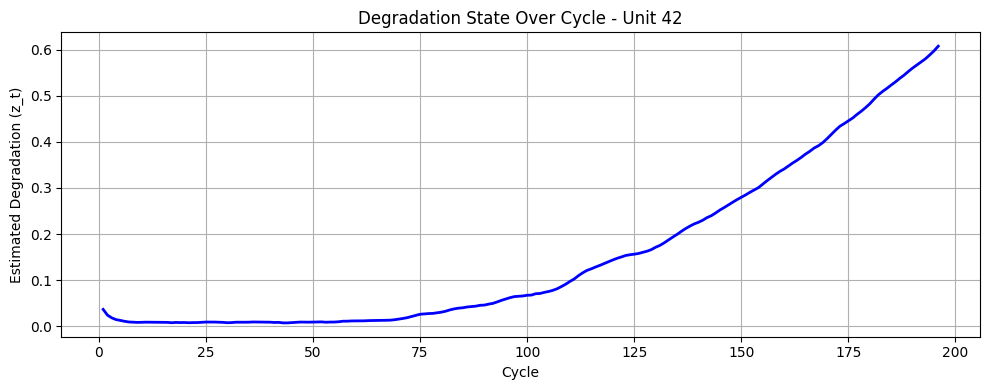

In [119]:
# === Plot Degradation vs. Cycle ===
plt.figure(figsize=(10, 4))
plt.plot(df_unit['cycle'], degradation_estimates, color='blue', linewidth=2)
plt.title(f"Degradation State Over Cycle - Unit {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Estimated Degradation (z_t)")
plt.grid(True)
plt.tight_layout()
plt.show()

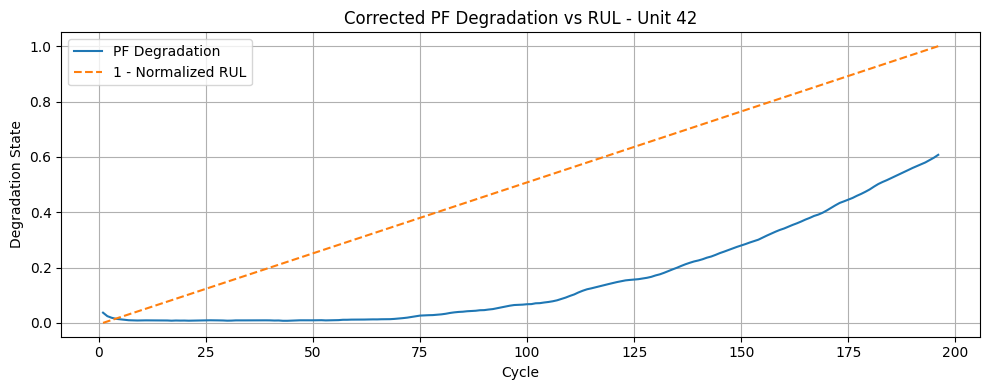

In [120]:
# === 7. Plot ===
plt.figure(figsize=(10, 4))
plt.plot(df_unit['cycle'], degradation_estimates, label='PF Degradation')
plt.plot(df_unit['cycle'], rul_normalized, label='1 - Normalized RUL', linestyle='--')
plt.title(f"Corrected PF Degradation vs RUL - Unit {unit_id}")
plt.xlabel("Cycle")
plt.ylabel("Degradation State")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [121]:
#  STEP 4:  Degradation Trend Extraction
# STEP 4A: Apply Particle Filter to All Units & Save Degradation Estimates


from tqdm import tqdm

# === Load smoothed dataset ===
data_path = "/content/drive/MyDrive/Project Dataset/MTP Dataset/smoothed_fd001.csv"
df = pd.read_csv(data_path)
sensor_cols = [col for col in df.columns if "sensor_" in col]

# === Compute global reference vectors ===
def get_reference_vectors(df, sensor_cols):
    healthy_vecs = []
    degraded_vecs = []
    for uid in df['unit'].unique():
        unit_df = df[df['unit'] == uid]
        healthy_vecs.append(unit_df.iloc[0][sensor_cols].values)
        degraded_vecs.append(unit_df.iloc[-1][sensor_cols].values)
    return np.mean(healthy_vecs, axis=0), np.mean(degraded_vecs, axis=0)

healthy_ref, degraded_ref = get_reference_vectors(df, sensor_cols)

# === Corrected Particle Filter class ===
class CorrectedPF:
    def __init__(self, num_particles=1000, sigma_process=0.005, sigma_obs=0.1):
        self.N = num_particles
        self.sigma_process = sigma_process
        self.sigma_obs = sigma_obs

    def initialize(self):
        self.particles = np.random.uniform(0, 1, self.N)
        self.weights = np.ones(self.N) / self.N

    def predict(self):
        noise = np.random.normal(0, self.sigma_process, self.N)
        self.particles = np.clip(self.particles + noise, 0, 1)

    def update(self, x_t, healthy, degraded):
        x_hats = np.outer(1 - self.particles, healthy) + np.outer(self.particles, degraded)
        errors = np.linalg.norm(x_hats - x_t, axis=1)
        self.weights = np.exp(-errors**2 / (2 * self.sigma_obs**2))
        self.weights += 1e-10
        self.weights /= np.sum(self.weights)

    def resample(self):
        if len(self.weights) != len(self.particles) or np.sum(self.weights) == 0:
            self.weights = np.ones(self.N) / self.N
        idx = np.random.choice(self.N, size=self.N, p=self.weights)
        self.particles = self.particles[idx]
        self.weights = np.ones(self.N) / self.N

    def estimate(self):
        return np.mean(self.particles)

# === Run PF for all units ===
def run_pf_all_units(df, sensor_cols, healthy, degraded):
    pf = CorrectedPF(num_particles=1000)
    degradation_records = []

    for uid in tqdm(df['unit'].unique(), desc="Processing Units"):
        unit_df = df[df['unit'] == uid].reset_index(drop=True)
        pf.initialize()
        for idx, row in unit_df.iterrows():
            x_t = row[sensor_cols].values
            pf.predict()
            pf.update(x_t, healthy, degraded)
            pf.resample()
            z_t = pf.estimate()
            degradation_records.append({
                'unit': uid,
                'cycle': row['cycle'],
                'degradation': z_t,
                'RUL': row['RUL']
            })

    return pd.DataFrame(degradation_records)

# === Execute & Save ===
degradation_df = run_pf_all_units(df, sensor_cols, healthy_ref, degraded_ref)
output_path = "/content/drive/MyDrive/Project Dataset/MTP Dataset/degradation_fd001.csv"
degradation_df.to_csv(output_path, index=False)
print(f"\n Degradation values saved to: {output_path}")



Processing Units: 100%|██████████| 100/100 [00:12<00:00,  7.72it/s]


✅ Degradation values saved to: /content/drive/MyDrive/Project Dataset/MTP Dataset/degradation_fd001.csv


In [122]:
# === Preview Sample Output for Verification ===
print("\n🔍 Sample of saved degradation data:")
print(degradation_df.head(10))



🔍 Sample of saved degradation data:
   unit  cycle  degradation    RUL
0     1    1.0     0.039352  191.0
1     1    2.0     0.025164  190.0
2     1    3.0     0.018449  189.0
3     1    4.0     0.015027  188.0
4     1    5.0     0.011551  187.0
5     1    6.0     0.009702  186.0
6     1    7.0     0.008011  185.0
7     1    8.0     0.007504  184.0
8     1    9.0     0.006921  183.0
9     1   10.0     0.006415  182.0


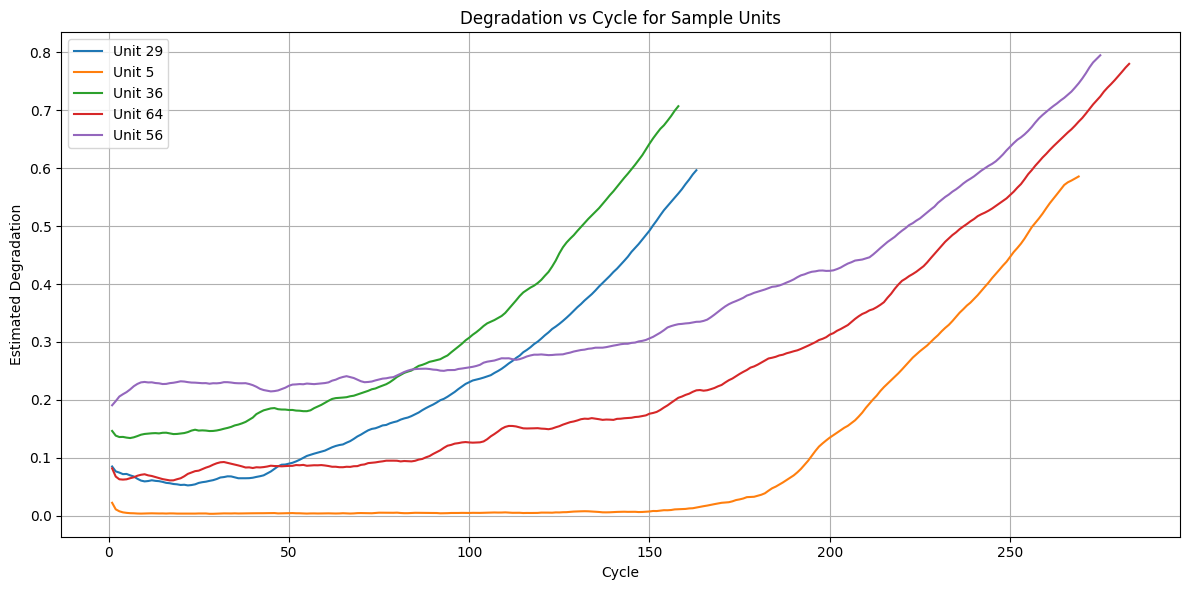

In [123]:
# === Plot: Degradation vs Cycle for Random Units ===
import random
sample_units = random.sample(list(degradation_df['unit'].unique()), 5)

plt.figure(figsize=(12, 6))
for uid in sample_units:
    unit_data = degradation_df[degradation_df['unit'] == uid]
    plt.plot(unit_data['cycle'], unit_data['degradation'], label=f'Unit {uid}')

plt.title("Degradation vs Cycle for Sample Units")
plt.xlabel("Cycle")
plt.ylabel("Estimated Degradation")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



📉 Training RUL predictor using degradation + cycle

✅ Linear Regression Results:
RMSE: 41.8514
MAE: 32.7366
R²: 0.6166


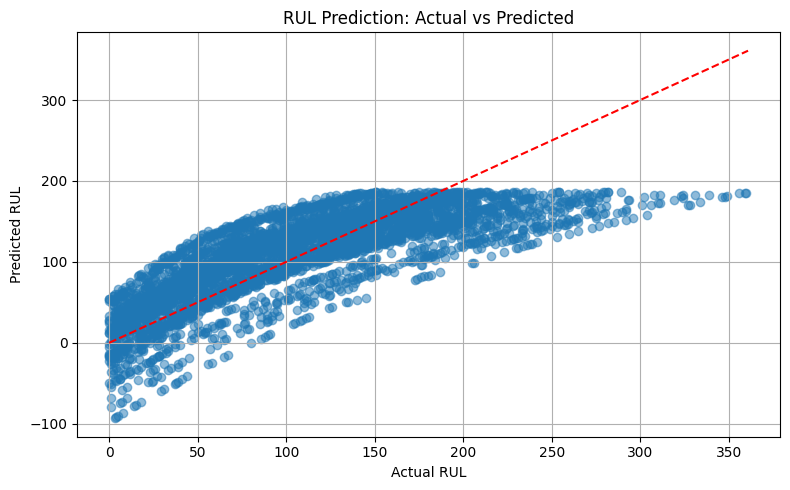

In [124]:
import random
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
# === STEP 4B: Train RUL Predictor Using Degradation Signal ===
print("\n Training RUL predictor using degradation + cycle")

# Features and target
X = degradation_df[["degradation", "cycle"]].values
y = degradation_df["RUL"].values

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"\n Linear Regression Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Plot prediction vs actual
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("RUL Prediction: Actual vs Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


In [144]:
print(" Sample y_test:", y_test[:10])
print(" Sample y_pred:", y_pred[:10])


🔍 Sample y_test: [135.   2. 217.   0. 178.  70.  87.  87.  73.  77.]
🔍 Sample y_pred: [ 23.540205  105.09831   134.35957    47.049774   43.796066   60.772495
  72.79952    84.55009     2.1710708 218.28421  ]


🔍 Sample of merged data:
Available columns: ['unit', 'cycle', 'degradation', 'RUL', 'op_setting_1', 'op_setting_2', 'op_setting_3', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_7', 'sensor_8', 'sensor_9', 'sensor_11', 'sensor_12', 'sensor_13', 'sensor_14', 'sensor_15', 'sensor_17', 'sensor_20', 'sensor_21', 'sensor_2_mean', 'sensor_2_std', 'sensor_3_mean', 'sensor_3_std', 'sensor_4_mean', 'sensor_4_std', 'sensor_7_mean', 'sensor_7_std', 'sensor_8_mean', 'sensor_8_std', 'sensor_9_mean', 'sensor_9_std', 'sensor_11_mean', 'sensor_11_std', 'sensor_12_mean', 'sensor_12_std', 'sensor_13_mean', 'sensor_13_std', 'sensor_14_mean', 'sensor_14_std', 'sensor_15_mean', 'sensor_15_std', 'sensor_17_mean', 'sensor_17_std', 'sensor_20_mean', 'sensor_20_std', 'sensor_21_mean', 'sensor_21_std']
   unit    cycle  degradation    RUL  degradation    cycle
0     1  0.00000     0.045217  191.0     0.045217  0.00000
1     1  0.00277     0.027623  190.0     0.027623  0.00277
2     1  0.00554     0.019296  189.0 

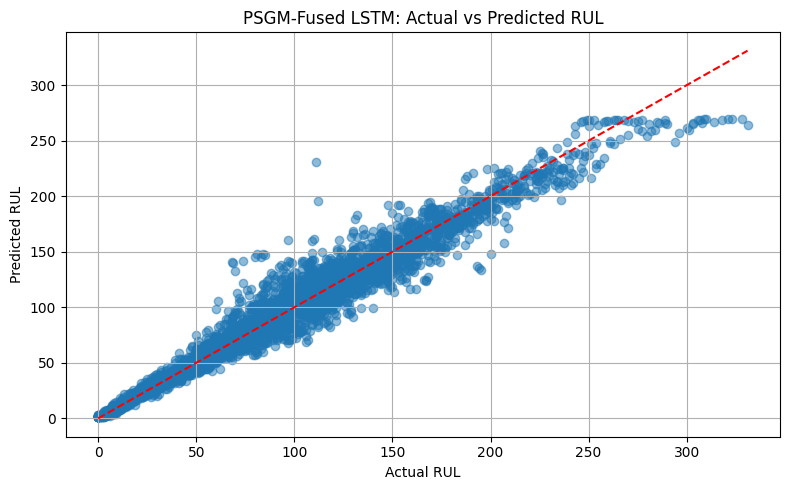

In [138]:
# STEP 5 (Modified): PSGM-Style LSTM with Sensor Feature Fusion

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# === Load Degradation CSV with RUL ===
data_path = "/content/drive/MyDrive/Project Dataset/MTP Dataset/degradation_fd001.csv"
df = pd.read_csv(data_path)

# Ensure 'RUL' exists
assert 'RUL' in df.columns, "RUL column missing in degradation file"

# === Load original smoothed sensor dataset ===
sensor_data = pd.read_csv("/content/drive/MyDrive/Project Dataset/MTP Dataset/smoothed_fd001.csv")

# === Sensor columns (same as used for PF) ===
sensor_cols = [col for col in sensor_data.columns if "sensor_" in col]

# === Merge degradation and smoothed sensor data ===
merged_df = pd.merge(df[["unit", "cycle", "degradation", "RUL"]], sensor_data, on=["unit", "cycle"])

# === Resolve RUL column conflict ===
if 'RUL_x' in merged_df.columns and 'RUL_y' in merged_df.columns:
    merged_df.drop(columns=['RUL_y'], inplace=True)
    merged_df.rename(columns={'RUL_x': 'RUL'}, inplace=True)

# === Compute rolling mean and std for sensor signals ===
for col in sensor_cols:
    merged_df[f"{col}_mean"] = merged_df.groupby("unit")[col].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    merged_df[f"{col}_std"] = merged_df.groupby("unit")[col].transform(lambda x: x.rolling(window=5, min_periods=1).std().fillna(0))

# === Feature list: degradation + cycle + sensor mean/std ===
feature_cols = ["degradation", "cycle"] + [f"{col}_mean" for col in sensor_cols] + [f"{col}_std" for col in sensor_cols]

# === Normalize Features ===
scaler = MinMaxScaler()
merged_df[feature_cols] = scaler.fit_transform(merged_df[feature_cols])

# === Debug print: show some data ===
print("🔍 Sample of merged data:")
print("Available columns:", merged_df.columns.tolist())

# Print sample only if RUL exists
if "RUL" in merged_df.columns:
    print(merged_df[["unit", "cycle", "degradation", "RUL"] + feature_cols[:2]].head())
else:
    print(" 'RUL' column not found in merged DataFrame. Available columns shown above.")

# === Define Sequence Dataset for PSGM model ===
class PSGMDataset(Dataset):
    def __init__(self, df, seq_len=30):
        self.seq_len = seq_len
        self.data = []
        grouped = df.groupby("unit")
        for _, unit_df in grouped:
            unit_df = unit_df.reset_index(drop=True)
            for i in range(len(unit_df) - seq_len):
                seq = unit_df.iloc[i:i+seq_len][feature_cols].values
                label = unit_df.iloc[i+seq_len]["RUL"]
                self.data.append((seq, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        seq, label = self.data[idx]
        return torch.tensor(seq, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

# === Define PSGM-inspired LSTM Model ===
class PSGM_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :]).squeeze()

# === Prepare Dataset and DataLoaders ===
seq_len = 30
dataset = PSGMDataset(merged_df, seq_len)
train_size = int(0.8 * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

# === Initialize model ===
input_dim = len(feature_cols)
model = PSGM_LSTM(input_size=input_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print("\n Training PSGM-style LSTM with sensor fusion...")

# === Train Model ===
best_val_loss = float('inf')
epochs = 100  # increased epochs
patience = 10
wait = 0
best_model_state = None

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    val_loss = 0.0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # === Validation loss ===
    model.eval()
    with torch.no_grad():
        for val_inputs, val_targets in test_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    avg_train_loss = running_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = model.state_dict()
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

# === Load best model ===
if best_model_state:
    model.load_state_dict(best_model_state)

# === Evaluate Model ===
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        y_true.extend(targets.numpy())
        y_pred.extend(outputs.numpy())

# === Metrics ===
y_true = np.array(y_true)
y_pred = np.array(y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print("\n PSGM-Fused LSTM Results:")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# === Plot Prediction ===
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.5)
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title("PSGM-Fused LSTM: Actual vs Predicted RUL")
plt.grid(True)
plt.tight_layout()
plt.show()


In [139]:
# STEP 6: Export Trained PSGM-LSTM Model and Scaler for Inference

import joblib
import os

# === Define export path on Google Drive ===
export_dir = "/content/drive/MyDrive/Project Dataset/MTP Dataset/exports"
os.makedirs(export_dir, exist_ok=True)

# === Save model state_dict ===
model_path = os.path.join(export_dir, "psgm_lstm_model.pt")
torch.save(model.state_dict(), model_path)
print(f" Saved model to: {model_path}")

# === Save MinMaxScaler ===
scaler_path = os.path.join(export_dir, "feature_scaler.pkl")
joblib.dump(scaler, scaler_path)
print(f" Saved scaler to: {scaler_path}")

# === Save feature column names ===
feature_list_path = os.path.join(export_dir, "feature_columns.txt")
with open(feature_list_path, "w") as f:
    for col in feature_cols:
        f.write(f"{col}\n")
print(f" Saved feature column list to: {feature_list_path}")


✅ Saved model to: /content/drive/MyDrive/Project Dataset/MTP Dataset/exports/psgm_lstm_model.pt
✅ Saved scaler to: /content/drive/MyDrive/Project Dataset/MTP Dataset/exports/feature_scaler.pkl
✅ Saved feature column list to: /content/drive/MyDrive/Project Dataset/MTP Dataset/exports/feature_columns.txt
